<a href="https://colab.research.google.com/github/lucaslapazini95/projetos_pyspark_soulcode/blob/main/pratica_analise_pyspark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install gcsfs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 42.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.0/154.0 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 10.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2023.3.0
    Uninstalling fsspec-2023.3.0:
      Successfully uninstalled fsspec-2023.3.0


In [ ]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from google.cloud import storage
import os
warnings.filterwarnings("ignore")

In [ ]:
#CONFIGURAR A CHAVE
serviceAccount = '/content/drive/MyDrive/Chave Bucket/strategic-grove-377720-ad70b805c6b7.json'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = serviceAccount

In [ ]:
#ACESSAR A BUCKET CRIADA
client = storage.Client()

bucket = client.get_bucket('desenvolvedores1')

bucket.blob('dataset.csv')

path = 'gs://desenvolvedores1/tratados/dataset.csv'

In [ ]:
#CONFIGURAR A VARIÁVEL DE AMBIENTE (SESSÃO)
spark = (SparkSession.builder
                     .master('local[2]')
                     .appName('ad1_pratica')
                     .config('spark.ui.port', '4050')
                     .config("spark.jars", 'https://storage.googleapis.com/hadoop-lib/gcs/gcs-connector-hadoop2-latest.jar')
                     .getOrCreate()
)

In [ ]:
#LER O CSV
df = (
    spark.read
         .format('csv')
         .option('delimiter', ',')
         .option('header', 'true')
         .option('inferschema', 'true')
         .load(path)
)

In [ ]:
#VISUALIZAR AS COLUNAS
df.printSchema()

root
 |-- customerid: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- salary: integer (nullable = true)
 |-- balance: integer (nullable = true)
 |-- marital: string (nullable = true)
 |-- jobedu: string (nullable = true)
 |-- targeted: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: string (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- response: string (nullable = true)



In [ ]:
#DROPAMOS A COLUNA DE ID, POIS ELA SERVE APENAS PARA IDENTIFICAR UM REGISTRO E NÃO SERÁ UTILIZADA NA NOSSA ANÁLISE
df = df.drop(F.col('customerid'))

In [ ]:
#SEPARAR A COLUNA job da coluna education (jobedu)
#CRIAR COLUNA JOB - F.split(F.col(), separador).getItem(0)
#CRIAR COLUNA EDUCATION - F.split(F.col(), separador).getItem(1)
df = ( df.withColumn('job', F.split(F.col('jobedu'), ',').getItem(0))
    .withColumn('education', F.split(F.col('jobedu'), ',').getItem(1))
)

In [ ]:
#NÃO PRECISAMOS MAIS DA COLUNA jobedu, ENTÃO VAMOS DROPÁ-LA
df = df.drop(F.col('jobedu'))

In [ ]:
#IREMOS ESCOLHER A MODA, POIS SÃO POUCOS REGISTROS E ISSO NÃO IRÁ CAUSAR UM IMPACTO
df = df.fillna(32, subset='age')

In [ ]:
#IMPUTANDO OS VALORES NULOS DE month PARA A MODA may, 2017
df = df.fillna('may, 2017', subset='month')

In [ ]:
#Substituição dos valores ausentes de salary para a mediana
df = df.fillna(60000, subset='salary')

In [ ]:
df = df.replace(0, 60000, subset='salary')

In [ ]:
#DROPAR AS LINHAS QUE POSSUEM O VALOR NULO EM response, POIS ELA É A NOSSA VARIÁVEL ALVO E NÃO
# PODEMOS IMPUTAR VALORES NELA
df = df.dropna(how='any', subset='response')
#df.filter(F.col('response').isNotNull())

In [ ]:
#Como a coluna pdays apresenta mais de 80% de valores ausentes, iremos dropá-la
df = df.drop(F.col('pdays'))

In [ ]:
# 1) QUANTIDADE DE PESSOAS POR CADA ESTADO CIVIL

df.groupBy(F.col('marital')).agg(F.count('marital').alias('Quantidade')).show()

+--------+----------+
| marital|Quantidade|
+--------+----------+
|divorced|      5204|
| married|     27195|
|  single|     12782|
+--------+----------+



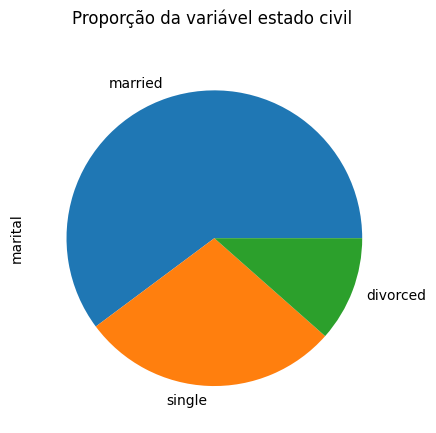

In [ ]:
df.toPandas().marital.value_counts().plot(kind = 'pie')
plt.title("Proporção da variável estado civil \n")
plt.show()

In [ ]:
# 2) QUANTIDADE DE PESSOAS POR CADA EMPREGO
df.groupBy(F.col('job')).agg(F.count('job').alias('Quantidade')).orderBy(F.col('Quantidade').desc()).show()

+-------------+----------+
|          job|Quantidade|
+-------------+----------+
|  blue-collar|      9727|
|   management|      9454|
|   technician|      7592|
|       admin.|      5166|
|     services|      4150|
|      retired|      2263|
|self-employed|      1575|
| entrepreneur|      1486|
|   unemployed|      1303|
|    housemaid|      1239|
|      student|       938|
|      unknown|       288|
+-------------+----------+



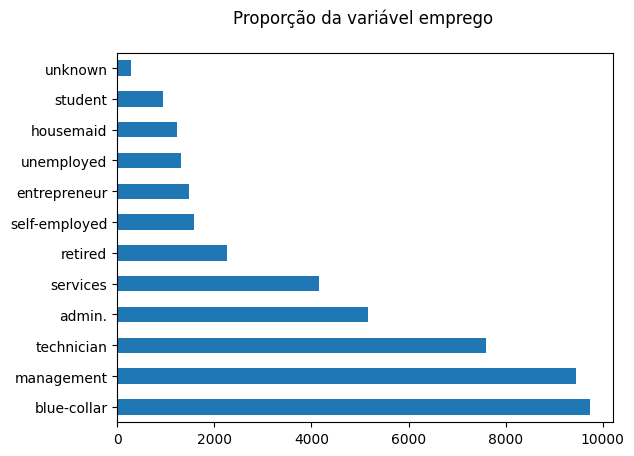

In [ ]:
df.toPandas().job.value_counts().plot(kind = 'barh')
plt.title("Proporção da variável emprego \n")
plt.show()

In [ ]:
# 3) QUANTIDADE DE PESSOAS POR NÍVEL EDUCACIONAL
df.groupBy(F.col('education')).agg(F.count('education').alias('Quantidade')).show()

+---------+----------+
|education|Quantidade|
+---------+----------+
|  unknown|      1856|
| tertiary|     13292|
|secondary|     23189|
|  primary|      6844|
+---------+----------+



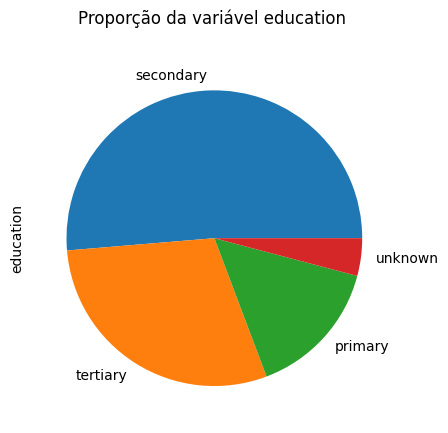

In [ ]:
df.toPandas().education.value_counts().plot(kind = 'pie')
plt.title("Proporção da variável education \n")
plt.show()

In [ ]:
# 4) QUANTIDADE DE RESPOSTAS SIM E NÃO
df.groupBy(F.col('response')).agg(F.count('response').alias('Quantidade')).orderBy(F.col('Quantidade').desc()).show()

+--------+----------+
|response|Quantidade|
+--------+----------+
|      no|     39894|
|     yes|      5287|
+--------+----------+



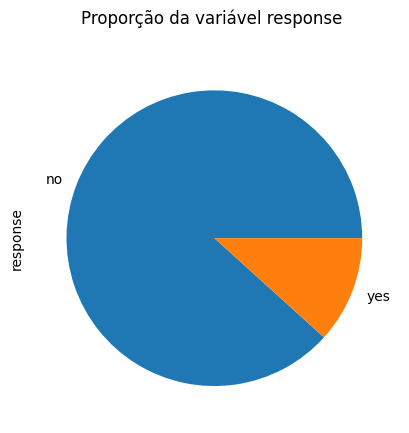

In [ ]:
df.toPandas().response.value_counts().plot(kind = 'pie')
plt.title("Proporção da variável response \n")
plt.show()

Estatística
- Correlação de Pearson - Soma (desvio padrão x . desvio padrão y) / quantidade de registros
Vai de -1 a +1

corr() - 0 (Não há correlação entre as duas colunas)
corr() - 1 (Há correlação Positiva, à medida que uma coluna aumenta, a outra também aumenta)
corr() - (-1) (hÁ Correlação Negativa, à medida que uma coluna aumenta, a outra diminui)

- Variância e Desvio Padrão

In [ ]:
resultado2 = df.toPandas()[['salary', 'balance', 'age']].corr()

In [ ]:
resultado2.head()

,salary,balance,age
salary,1.000000,0.057609,0.032272
balance,0.057609,1.000000,0.097729
age,0.032272,0.097729,1.000000


In [ ]:
df_pandas = df.toPandas()

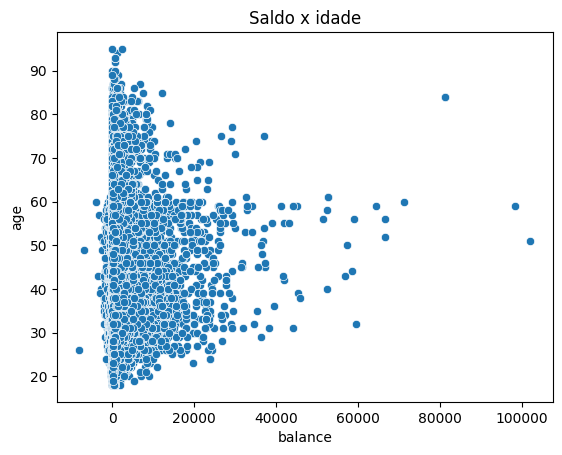

In [ ]:
sns.scatterplot(data = df_pandas, x='balance', y='age')
plt.title('Saldo x idade')
plt.show()

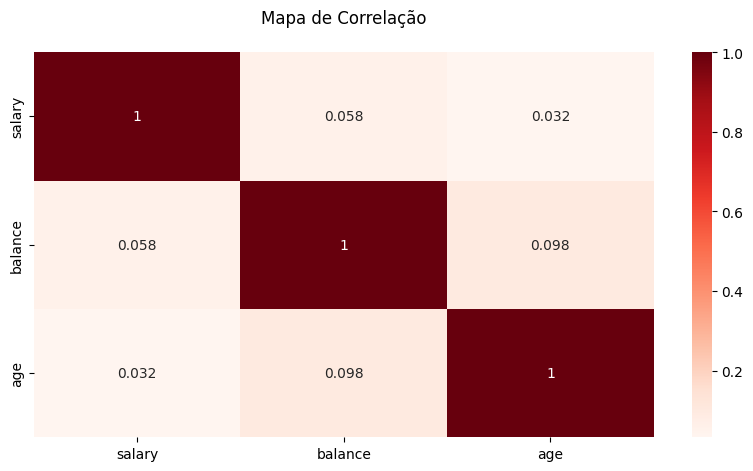

In [ ]:
plt.figure(figsize = (10, 5))
sns.heatmap(resultado2, annot= True, cmap = "Reds")
plt.title("Mapa de Correlação\n")
plt.show()

In [ ]:
df.groupBy('response').F.avg('salary')

AttributeError: ignored